In [169]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras import Model
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler as StandardScaler
from sklearn.model_selection import train_test_split as ttsplit
from sklearn.metrics import mean_squared_error
import uproot 
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import legend
from tensorflow.keras import layers
import tensorflow as tf
import tensorflow
from keras.models import load_model
from keras import Model



In [322]:
dir = "/Users/mykola/Physics/CaloML/My_sim/calo_sim/calo_sim/"
file = "var_sim_20k.root"
#file = "calo_out_10k_p1.root"
input_data = uproot.open(dir+file)
calotree = input_data["CaloSimTree"]
branches = calotree.arrays()
print (calotree.keys())
cell_e_truth = calotree["Cell_E_truth_L2"]
tau_truth = np.array(branches["tau_0"])
Energy_L2 = np.array(branches["Energy_L2"])

e_truth = np.array(branches["Cell_E_truth_L2"])
np.stack(e_truth).shape
tau_clean = np.array(branches["Cell_t_reco_noise_L2"])
e_noise = np.array(branches["Cell_E_reco_noise_L2"])
e_XT = np.array(branches["Cell_E_reco_noiseXT_L2"])
impact_e = np.array(branches["Impact_Energy"])
tau_xt = np.array(branches["Cell_t_reco_noiseXT_L2"])
ai = np.array(branches["ai"])
bi = np.array(branches["bi"])

['Cell_E_truth_L2', 'Cell_E_reco_noise_L2', 'Cell_E_reco_noiseXT_L2', 'Cell_E_fake_L2', 'Cell_t_reco_noise_L2', 'Cell_t_reco_noiseXT_L2', 'Cell_t_fake_L2', 'Cell_t_delay_L2', 'Cell_signal_samples_L2', 'Cell_noise_samples_L2', 'Cell_XTc_samples_L2', 'Cell_XTl_samples_L2', 'Energy_L2', 'Impact_Energy', 'tau_0', 'xtc_amplitude_l2', 'xtl_amplitude_l2', 'ai', 'bi']


In [320]:
for el in impact_e:
    if np.any(el<0):
        print (el)

-648.4799173862035
-10666.909063152072
-3854.5055159798303


TypeError: 'module' object is not callable

In [64]:
from sklearn.preprocessing import StandardScaler as StandardScaler
scaler  = StandardScaler()

def cube (x):
    return x**2.4

def data_preparation(input_df):    
    e_truth = np.array(input_df["Cell_E_truth_L2"])
    e_truth = np.repeat(e_truth, 4, axis=1)
    signal_truth = np.array(input_df["Cell_signal_samples_L2"])
    noise = np.array(input_df["Cell_noise_samples_L2"])
    xtc_amplitude = np.array(input_df["xtc_amplitude_l2"])
    xtc_amplitude = np.repeat(xtc_amplitude, 4, axis=1)
    xtl_amplitude = np.array(input_df["xtl_amplitude_l2"])
    xtl_amplitude = np.repeat(xtl_amplitude, 4, axis=1)
    Cell_XTc_samples_L2 = np.array(input_df["Cell_XTc_samples_L2"])
    Cell_XTl_samples_L2 = np.array(input_df["Cell_XTl_samples_L2"])
    tau_0 = np.array(input_df["tau_0"])
    sumAll = e_truth*signal_truth + noise + xtc_amplitude*Cell_XTc_samples_L2 + xtl_amplitude*Cell_XTl_samples_L2
    sumXT = xtc_amplitude*Cell_XTc_samples_L2 + xtl_amplitude*Cell_XTl_samples_L2
    sumAll = scaler.fit_transform(sumAll)
    sumAll = sumAll.reshape(sumAll.shape[0],5,5,4,1)
    sumAll = sumAll.swapaxes(1,3)
    clean_signal = e_truth*signal_truth
    clean_signal = clean_signal.reshape(clean_signal.shape[0],5,5,4,1)
    clean_signal = clean_signal.swapaxes(1,3)

    sumXT = sumXT.reshape(sumXT.shape[0],5,5,4,1)
    sumXT = sumXT.swapaxes(1,3)

    return sumAll,sumXT,clean_signal

def OptimalFilter(signals,ai,bi):
    signals = signals.swapaxes(1,3)
    signals = signals.reshape(signals.shape[0], 25,4)
    energy = np.dot(signals,ai)
    etau = np.dot(signals,bi)
    tau = etau/energy
    return energy.sum(axis=1), tau.mean(axis=1)

def OptimalFilter_TF(signals):
    ai = tf.constant([0.3594009 , 0.49297974, 0.38133506, 0.24622458])
    bi = tf.constant([-18.92073871,   0.90162148,  14.33011022,   6.34564695])
    energy = tf.tensordot(signals,ai,axes=[[2], [0]])
    etau = tf.tensordot(signals,bi,axes=[[2], [0]])
    tau = etau/energy
    return energy, tau
#    return tf.reduce_sum(energy,1), tf.math.reduce_mean(etau,1)
    
def OptimalFilter_energy(signals):
    ai = tf.constant([0.3594009 , 0.49297974, 0.38133506, 0.24622458])
    bi = tf.constant([-18.92073871,   0.90162148,  14.33011022,   6.34564695])
    energy = tf.tensordot(signals,ai,axes=[[2], [0]])
    etau = tf.tensordot(signals,bi,axes=[[2], [0]])
    tau = etau/energy
    return tf.reduce_sum(energy,1)

def OptimalFilter_tau(signals):
    ai = tf.constant([0.3594009 , 0.49297974, 0.38133506, 0.24622458])
    bi = tf.constant([-18.92073871,   0.90162148,  14.33011022,   6.34564695])
    energy = tf.tensordot(signals,ai,axes=[[2], [0]])
    etau = tf.tensordot(signals,bi,axes=[[2], [0]])
    tau = etau/energy
    return tf.math.reduce_mean(tau,1)


def OF_loss_energy_MSE (y_true, y_pred): 
    return tf.keras.losses.MSE(y_true, y_pred)
    
def OF_loss_tau (y_true, y_pred):
    return tf.math.reduce_std(y_pred)


In [40]:
models_dir= "/Users/mykola/Google Drive/CaloML/Models/"
model_name = "mse_top.h5"
save_all = tensorflow.keras.callbacks.ModelCheckpoint(models_dir+'weights.{epoch:02d}-{val_loss:.2f}.h5', monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
corr_model = load_model(models_dir+model_name)


In [54]:
in_shape = (4, 5, 5,1)
import keras
inputs = keras.Input(shape=in_shape)
x       = layers.Permute((3,2,1,4))(inputs)
x       = layers.Reshape((25,4))(x)
x = layers.Lambda(OptimalFilter_TF)(x)

ofilter = keras.Model(inputs, outputs={"energy":x[0],"tau":x[1]}, name="ofilter_output")
ofilter.output_shape

{'energy': (None, 25), 'tau': (None, 25)}

In [175]:
inputs    = keras.Input(shape=in_shape)

corrector = corr_model(inputs)
optimal_filter = ofilter(corrector)

filtered_corrector = keras.Model(inputs, outputs={"energy":optimal_filter["energy"], "tau": optimal_filter["tau"]},name = "stacked")
opt = keras.optimizers.Adam(learning_rate=0.001)
#opt = keras.optimizers.SGD(learning_rate=1e-15)

filtered_corrector.compile(optimizer=opt, 
                loss={'energy':"MSE", 'tau':OF_loss_tau},
              loss_weights=[1,0.5])

In [56]:
signal, xtalk, clean = data_preparation(branches)

pred = filtered_corrector(signal)

In [149]:
import math
import numpy as np
from matplotlib import cm
from matplotlib.colors import LogNorm

def plot_cluster(y):
    y_max = np.amax(y)
    f = figure(figsize=(6.2,5.6))
    ax = f.add_axes([0.17, 0.02, 0.72, 0.79])
    axcolor = f.add_axes([0.90, 0.02, 0.03, 0.79])
    im = ax.matshow(y, cmap=cm.Reds, norm=LogNorm(vmin=1, vmax=y_max))
    for (i, j), z in np.ndenumerate(y):
        ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
    t = 10**np.arange(0, math.log(y_max,10))
    f.colorbar(im, cax=axcolor, ticks=t, format='$%.2f$')
    f.legend()
    f.show()
    
def plot_cluster_lin(y):
    y_max = np.amax(y)
    f = figure(figsize=(6.2,5.6))
    ax = f.add_axes([0.17, 0.02, 0.72, 0.79])
    axcolor = f.add_axes([0.90, 0.02, 0.03, 0.79])
    im = ax.matshow(y, cmap=cm.Reds)
    for (i, j), z in np.ndenumerate(y):
        ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
    t = 10**np.arange(0, y_max)
    f.colorbar(im, cax=axcolor, ticks=t, format='$%.2f$')
    f.legend()
    f.show()
    
def get_average_cluster(x):
    x = np.stack(x)
    x = x.reshape(x.shape[0],5,5)
    y = np.mean(x, axis=0)
    return y

def get_std_cluster(x):
    x = np.stack(x)
    x = x.reshape(x.shape[0],5,5)
    y = np.std(x, axis=0)
    return y

No handles with labels found to put in legend.
<ipython-input-149-4b4e30559edf>:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


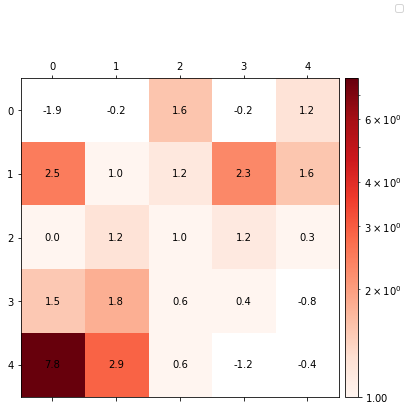

In [329]:
plot_cluster (get_average_cluster((np.array(pred["energy"]))/e_truth))

No handles with labels found to put in legend.
<ipython-input-149-4b4e30559edf>:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


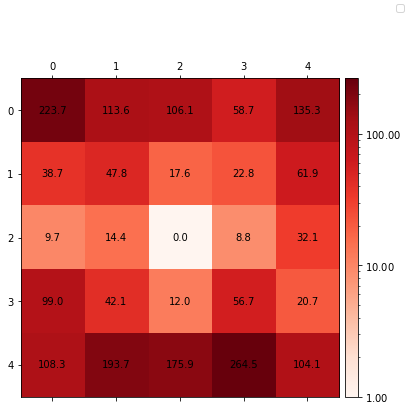

In [184]:
plot_cluster (get_std_cluster((np.array(pred["energy"])-e_truth)/e_truth))

No handles with labels found to put in legend.
<ipython-input-149-4b4e30559edf>:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


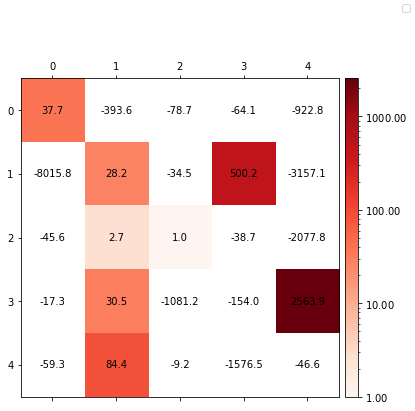

In [330]:
plot_cluster (get_average_cluster((np.array(pred["tau"])/tau_clean)))

No handles with labels found to put in legend.
<ipython-input-149-4b4e30559edf>:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


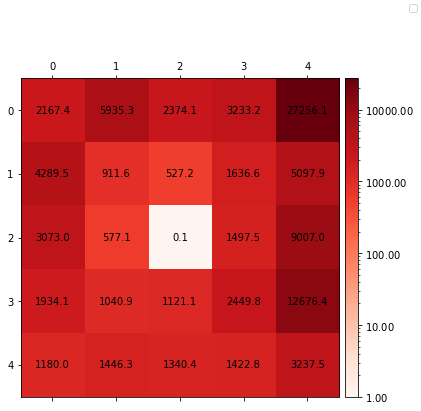

In [182]:
plot_cluster (get_std_cluster((np.array(pred["tau"])-tau_clean)))

In [98]:
models_dir= "/Users/mykola/Google Drive/CaloML/Models/"
model_name = "mape_top.h5"
save_all = tensorflow.keras.callbacks.ModelCheckpoint(models_dir+'weights.{epoch:02d}-{val_loss:.2f}.h5', monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
corr_model = load_model(models_dir+model_name)


In [100]:
pred_mape = filtered_corrector(signal)

No handles with labels found to put in legend.
<ipython-input-149-4b4e30559edf>:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


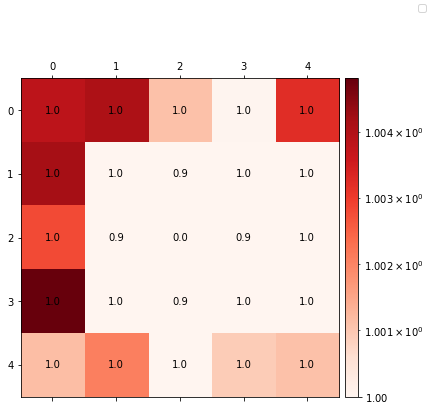

In [328]:
plot_cluster (get_average_cluster((np.array(pred_mape["energy"]))/e_truth))

No handles with labels found to put in legend.
<ipython-input-149-4b4e30559edf>:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


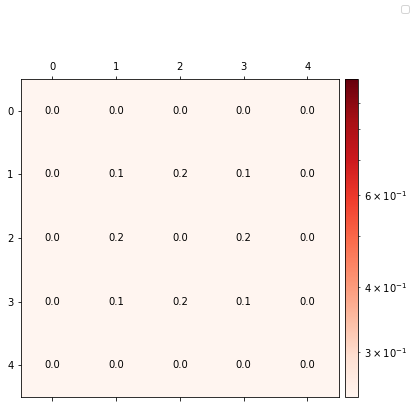

In [324]:
plot_cluster (get_std_cluster((np.array(pred_mape["energy"])-e_truth)/e_truth))

No handles with labels found to put in legend.
<ipython-input-149-4b4e30559edf>:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


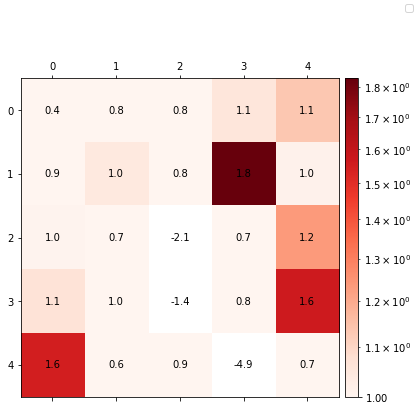

In [331]:
plot_cluster (get_average_cluster((np.array(pred_mape["tau"])/tau_clean)))

No handles with labels found to put in legend.
<ipython-input-149-4b4e30559edf>:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


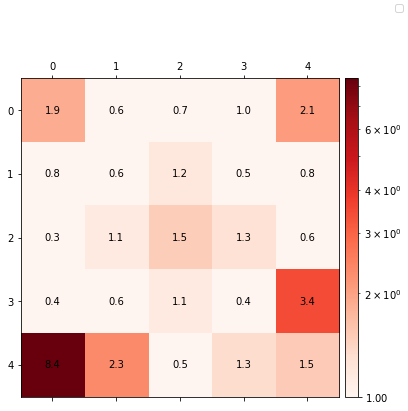

In [180]:
plot_cluster (get_std_cluster((np.array(pred_mape["tau"])-tau_clean)))

In [171]:
models_dir= "/Users/mykola/Google Drive/CaloML/Models/"
model_name = "mse_mape.h5"
save_all = tensorflow.keras.callbacks.ModelCheckpoint(models_dir+'weights.{epoch:02d}-{val_loss:.2f}.h5', monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
corr_model.load_weights(models_dir+model_name)


In [176]:
pred_mse_mape = filtered_corrector(signal)

No handles with labels found to put in legend.
<ipython-input-149-4b4e30559edf>:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


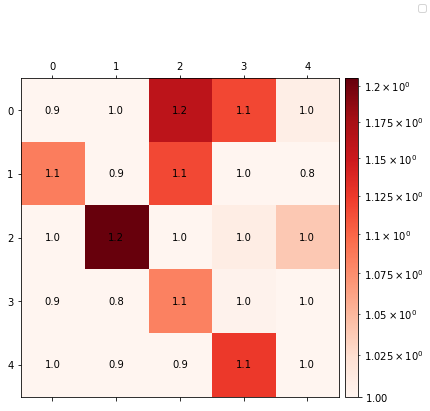

In [333]:
plot_cluster (get_average_cluster((np.array(pred_mse_mape["energy"]))/e_truth))

No handles with labels found to put in legend.
<ipython-input-149-4b4e30559edf>:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


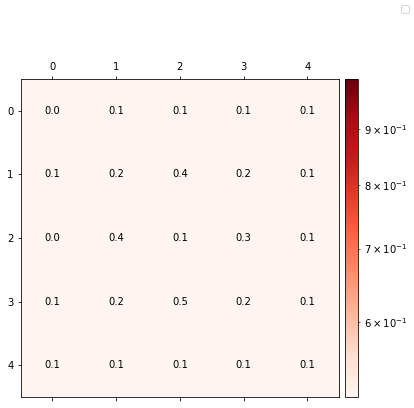

In [177]:
plot_cluster (get_std_cluster((np.array(pred_mse_mape["energy"])-e_truth)/e_truth))

No handles with labels found to put in legend.
<ipython-input-149-4b4e30559edf>:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


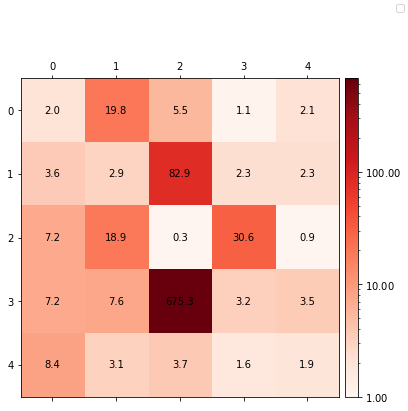

In [178]:
plot_cluster (get_std_cluster((np.array(pred_mse_mape["tau"])-tau_clean)))

No handles with labels found to put in legend.
<ipython-input-149-4b4e30559edf>:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


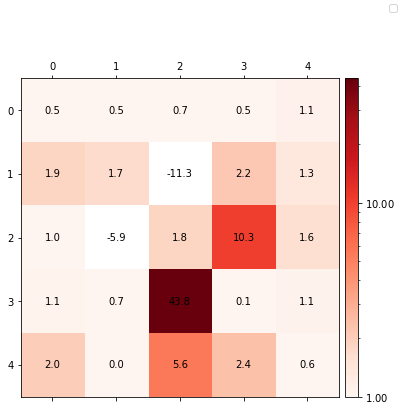

In [334]:
plot_cluster (get_average_cluster((np.array(pred_mse_mape["tau"])/tau_clean)))

In [206]:
from matplotlib.pyplot import figure 
import matplotlib.pyplot as plt
def plot_tau(x, lab, col):
    figure(figsize=(8, 6), dpi=80)
    x_max, _ ,_ = plt.hist(x, range=(x.mean()-3*x.std(),x.mean()+3*x.std()), bins = 30, label = lab, color = col)
    plt.text(x.mean()-3*x.std(), x_max.max()*0.85, f"mean: {round(x.mean(), 3)}", fontsize=20)    
    plt.text(x.mean()-3*x.std(), x_max.max()*0.7, f"std: {round(x.std(), 3)}", fontsize=20)    
    plt.xlabel("tau reco")
    plt.legend(prop={"size":20})
    plt.show()
    
#Function to plot the sum of energies
def plot_e(x, lab, col):
    x = np.stack(x)
    x = np.array([x.sum() for x in x]) 
    figure(figsize=(8, 6), dpi=80)
    x_max, _ ,_ = plt.hist(x, range=(x.mean()-3*x.std(),x.mean()+3*x.std()), bins = 30, label = lab, color = col)
    plt.text(x.mean()-3*x.std(), x_max.max()*0.85, f"mean: {round(x.mean(), 1)}", fontsize=20)    
    plt.text(x.mean()-3*x.std(), x_max.max()*0.7, f"std: {round(x.std(), 3)}", fontsize=20)    

    plt.xlabel("E reco")
    plt.legend(prop={"size":20})
    plt.show()


In [203]:
np.array(pred["tau"]).mean(axis=1)

array([  0.524314,  -2.79141 , 156.1338  , ..., 166.43982 ,  42.366913,
         5.38984 ], dtype=float32)

In [ ]:
##diff = tau_clean.mean() - tau_truth
#diff = np.array(pred["tau"]) - np.transpose(tau_clean)[12]
#diff = tau_truth - np.transpose(tau_clean)[12]
#diff = tau_truth - np.transpose(tau_clean)[12]
#diff = tau_truth - np.transpose(tau_xt)[12]
#diff = tau_truth - np.transpose(np.array(pred["tau"]))[12]

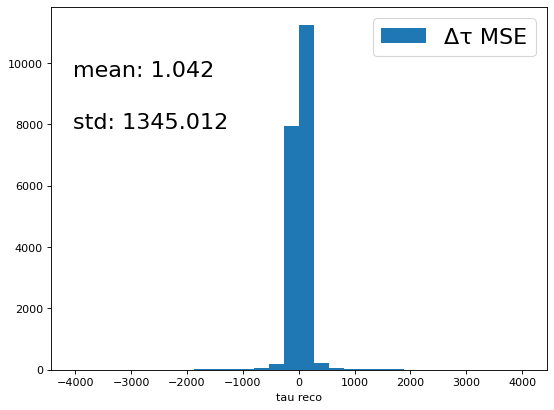

In [283]:
diff = np.array(pred["tau"]).mean(axis=1) - tau_truth 
plot_tau(diff, "Δτ MSE", None)

array([51235.59140887, 48681.59072793, 49176.90363029, ...,
       25552.54621611, 48368.36710106, 51428.13962004])

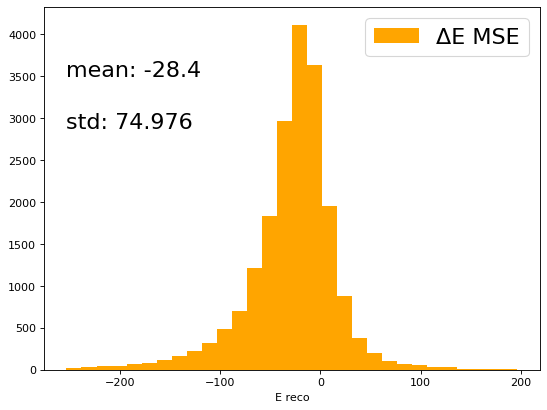

In [284]:
diff = np.array(pred["energy"]).sum(axis=1) - e_truth.sum(axis=1) 
plot_e(diff, "ΔE MSE", "orange")

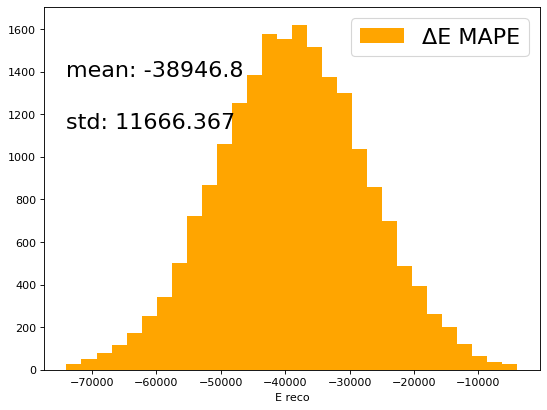

In [285]:
diff = np.array(pred_mape["energy"]).sum(axis=1) - e_truth.sum(axis=1) 
plot_e(diff, "ΔE MAPE", "orange")

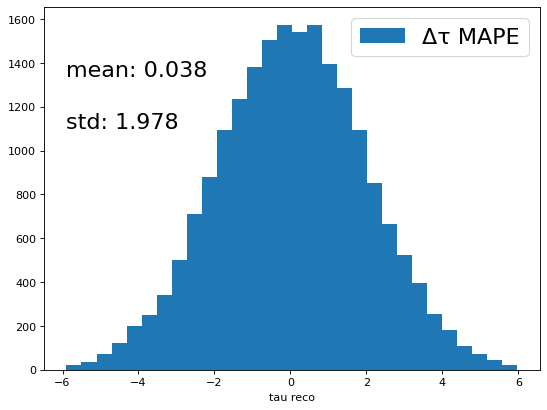

In [282]:
diff = np.array(pred_mape["tau"]).mean(axis=1) - tau_truth 
plot_tau(diff, "Δτ MAPE", None)

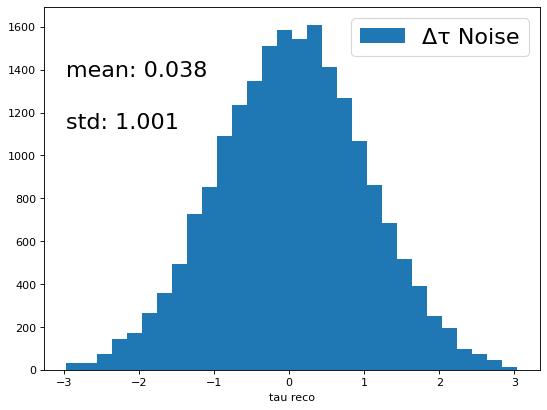

In [289]:
diff = np.array(pred_mape["tau"]).mean() - tau_truth 
plot_tau(diff, "Δτ Noise", None)

In [246]:
e_truth.sum(axis=1)

array([51235.59140887, 48681.59072793, 49176.90363029, ...,
       25552.54621611, 48368.36710106, 51428.13962004])

In [227]:
e_noise.sum(axis=1)

array([51231.31406138, 48681.56849427, 49176.86129949, ...,
       25552.51985064, 48366.09226961, 51379.60654021])

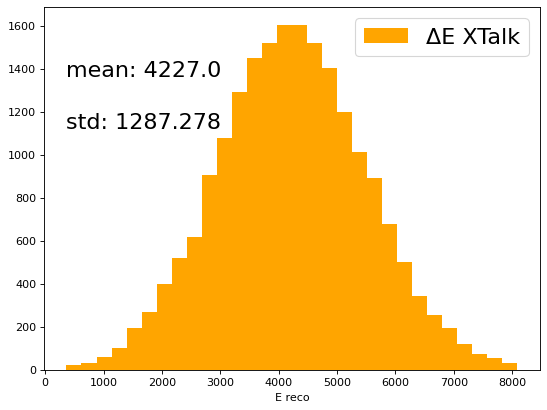

In [279]:
diff = (e_XT - e_truth).sum(axis=1)
plot_e(diff, "ΔE XTalk", "orange")

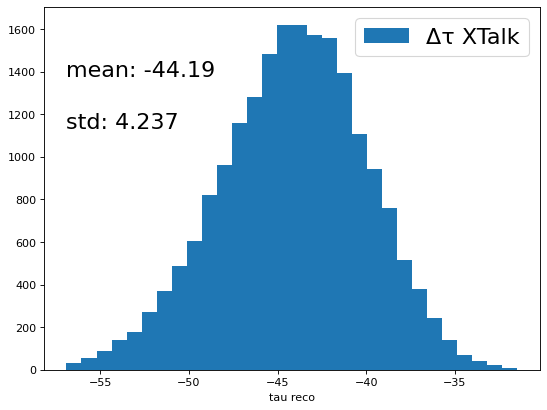

In [290]:
diff = tau_xt.mean(axis=1)
plot_tau(diff, "Δτ XTalk", None)

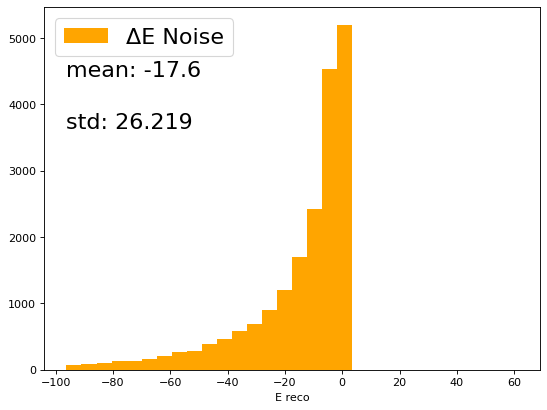

In [292]:
diff = (e_noise - e_truth).sum(axis=1)
plot_e(diff, "ΔE Noise", "orange")

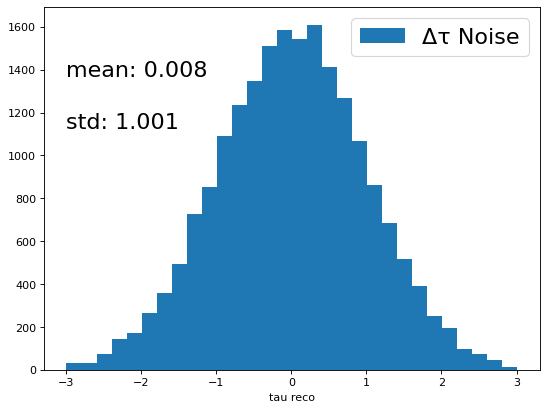

In [293]:
diff = tau_clean.mean() - tau_truth 
plot_tau(diff, "Δτ Noise", None)

In [149]:
from tensorflow.keras.models import load_model

WORK_DIR = "/Users/mykola/Google Drive/CaloML/"
hz = load_model(WORK_DIR+"Models/"+"weights.150-477.14.h5")
save_all = tf.keras.callbacks.ModelCheckpoint(WORK_DIR+"Models/"+'weights.{epoch:02d}-{val_loss:.2f}.h5', monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)


In [20]:
pred = hz(signal)

In [30]:
np.array(ofilter(pred)[1]).std()

14299.051

In [63]:
OptimalFilter(np.array(pred["energy"]),ai[0],bi[0])[0]

ValueError: cannot reshape array of size 500000 into shape (20000,25,4)

In [140]:
from tensorflow.keras.models import load_model

WORK_DIR = "/Users/mykola/Google Drive/CaloML/"
hz = load_model(WORK_DIR+"Models/"+"weights.150-477.14.h5")
save_all = tf.keras.callbacks.ModelCheckpoint(WORK_DIR+"Models/"+'weights.{epoch:02d}-{val_loss:.2f}.h5', monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)


In [304]:
inputs    = keras.Input(shape=in_shape)

corrector = hz(inputs)
optimal_filter = ofilter(corrector)

filtered_corrector = keras.Model(inputs, outputs={"energy":optimal_filter["energy"], "tau": optimal_filter["tau"]},name = "stacked")

filtered_corrector.compile(optimizer='Adam', 
                loss={'energy':OF_loss_energy_MSE, 'tau':OF_loss_tau},
              loss_weights=[1,1],
                           #loss="MSE"
                #loss_weights=[0,0]
                          )

In [272]:
def OF_loss_energy_MSE (y_true, y_pred): 
    return tf.keras.losses.MSE(y_true, y_pred)

In [102]:
signal, xt, clean_sig = data_preparation(branches)
train,test,xt_train,xt_test = ttsplit(signal, Energy_L2, test_size = 0.1, random_state=123)
#,callbacks=[save_all]


In [313]:
a = filtered_corrector.fit (train,(xt_train, batch_size = 128, epochs = 1, validation_split = 0.1 )

127/127 [==============================] - 46s 366ms/step - loss: 5719132.0000 - ofilter_output_loss: 5714380.5000 - ofilter_output_1_loss: 4751.9727 - val_loss: 5981603.5000 - val_ofilter_output_loss: 5981270.0000 - val_ofilter_output_1_loss: 332.4301


In [314]:
pred = filtered_corrector(test)

In [315]:
pred["energy"]

<tf.Tensor: shape=(2000,), dtype=float32, numpy=
array([48437.582, 41073.82 , 13289.715, ..., 40962.27 , 32440.012,
       51229.266], dtype=float32)>

In [316]:
pred["tau"]

<tf.Tensor: shape=(2000,), dtype=float32, numpy=
array([-19.963879 ,  -4.6475587, 165.1031   , ...,  90.17312  ,
        -8.282521 ,   4.8458767], dtype=float32)>

In [291]:
np.array(pred[1])

KeyError: 1

In [194]:
tf.keras.losses.MSE(xt_test,(pred) )

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([3.2868105e+04, 1.6671291e+09], dtype=float32)>

In [87]:
xt_test

array([49058.79922125, 39893.74355346, 16384.13167067, ...,
       40894.93626892, 31716.61122344, 53974.56807904])

In [95]:
xt_test

array([49058.79922125, 39893.74355346, 16384.13167067, ...,
       40894.93626892, 31716.61122344, 53974.56807904])

In [216]:
OF_loss_energy_MSE(xt_test,pred)

<tf.Tensor: shape=(), dtype=float32, numpy=20505.607>